# Biostat M280 Homework 2

**Due May 11 @ 11:59PM**

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
    )
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

In [319]:
# possible for efficiency: column major/ use blas or lapack/overwrite the initial V and W
function nnmf(
    X::Matrix{T}, 
    r::Int;
    maxiter::Int=1000, 
    tol::T=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    # implementation
    m = size(X,1)
    n = size(X,2)
    # proallocate. capital letter is for matrix, lowercase "t" means matrix transpose.
    XWt = zeros(m, r)
    
    WWt = zeros(r, r)
    VWWt = zeros(m, r)
    
    VtX = zeros(r, n)
    
    #VtV = zeros(r ,r)
    VtVW = zeros(r,n)
    #B = zeros(X)
    
    VW = zeros(X)
    #X_VW = zeros(X)
    
    for iter = 1:maxiter

        V .= V .* A_mul_Bt!(XWt, X, W)./ A_mul_B!(VWWt, V, A_mul_Bt!(WWt, W, W))
        #to update matrix W
       
        #W .= W .* At_mul_B!(VtX, V, X) ./ A_mul_B!(VtVW, At_mul_B!(VtV, V, V), W)
        # if reaches maxiter (and not satisfy the tolerance, stop with error message)
        W .= W .* At_mul_B!(VtX, V, X) ./ A_mul_B!(VtVW, At_mul_B!(WWt, V, V), W)


        
        VW .= X .- A_mul_B!(VW, V, W)
        
        f_normdiff_square = (vecnorm(VW))^2
        if f_normdiff_square < tol
           break
        end
    end
    # Output
    return V, W
end

nnmf (generic function with 1 method)

In [320]:
using BenchmarkTools
#matrixt = readdlm(download("http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt"));
@benchmark nnmf(matrixt, 20)

BenchmarkTools.Trial: 
  memory estimate:  7.97 MiB
  allocs estimate:  16
  --------------
  minimum time:     6.276 s (0.00% GC)
  median time:      6.276 s (0.00% GC)
  mean time:        6.276 s (0.00% GC)
  maximum time:     6.276 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

**(2)**. Display a few images 

In [99]:
Pkg.add("PyPlot")

INFO: Package PyPlot is already installed
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [100]:
using ImageView, Images, PyPlot
matrixt = readdlm(download("http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt"));

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6012k  100 6012k    0     0  3911k      0  0:00:01  0:00:01 --:--:-- 3909k


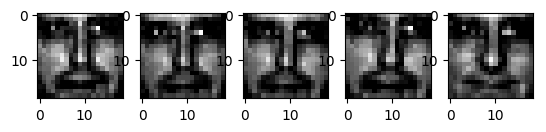

In [313]:
noimages = 5
for i in 1:noimages
    subplot(1,5,i)
    PyPlot.imshow(reshape(matrixt[i, :], 19, 19), cmap = "gray")
end

In [32]:
Pkg.test("ImageView")

INFO: Computing test dependencies for ImageView...
INFO: No packages to install, update or remove
INFO: Testing ImageView


Test Summary: | Pass  Total
contrast GUI  |    1      1


INFO: Could not find lighthouse in directory. Checking if it exists in the online repository.
INFO: Found lighthouse in the online repository. Downloading to the images directory.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145    0   145    0     0    301      0 --:--:-- --:--:-- --:--:--   301
100   156  100   156    0     0    237      0 --:--:-- --:--:-- --:--:--   237
100  622k  100  622k    0     0   591k      0  0:00:01  0:00:01 --:--:-- 3326k
INFO: Could not find mountainstream in directory. Checking if it exists in the online repository.
INFO: Found mountainstream in the online repository. Downloading to the images directory.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   149    0   149    0     0    322      0 --:--:-- --:--:-- --:--:--   323


Test Summary: | Pass  Total
CLim          |    2      2
Test Summary: | Pass  Total
sliceinds     |   22     22
Test Summary: | Pass  Total
SliceData     |   32     32
Test Summary: | Pass  Total
Canvas size   |    3      3
Test Summary: | Pass  Total
Aspect ratio  |    6      6


ERROR: LoadError: LoadError: InexactError()
Stacktrace:
 [1] trunc(::Type{Int64}, ::Float32) at ./float.jl:672
 [2] searchsortedfirst(::StepRangeLen{Float16,Base.TwicePrecision{Float16},Base.TwicePrecision{Float16}}, ::Float16, ::Base.Order.ForwardOrdering) at ./sort.jl:166
 [3] _edge_binindex at /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/StatsBase/src/hist.jl:181 [inlined]
 [4] (::StatsBase.##93#94{StatsBase.Histogram{Int64,1,Tuple{StepRangeLen{Float16,Base.TwicePrecision{Float16},Base.TwicePrecision{Float16}}}}})(::StepRangeLen{Float16,Base.TwicePrecision{Float16},Base.TwicePrecision{Float16}}, ::Float16) at /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/StatsBase/src/hist.jl:177
 [5] push!(::StatsBase.Histogram{Int64,1,Tuple{StepRangeLen{Float16,Base.TwicePrecision{Float16},Base.TwicePrecision{Float16}}}}, ::Tuple{Float16}, ::Int64) at /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/StatsBase/src/hist.jl:2

==============================[ ERROR: ImageView ]==============================

failed process: Process(`/Applications/JuliaPro-0.6.2.2.app/Contents/Resources/julia/Contents/Resources/julia/bin/julia -Cx86-64 -J/Applications/JuliaPro-0.6.2.2.app/Contents/Resources/julia/Contents/Resources/julia/lib/julia/sys.dylib --compile=yes --depwarn=yes --check-bounds=yes --code-coverage=none --color=yes --compilecache=yes /Applications/JuliaPro-0.6.2.2.app/Contents/Resources/pkgs-0.6.2.2/v0.6/ImageView/test/runtests.jl`, ProcessExited(1)) [1]

INFO: No packages to install, update or remove


LoadError: [91mImageView had test errors[39m

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

**(1)** In matrix notation
$$
 \mathbf{y} = \mathbf{X} \beta + \mathbf{Z} \gamma + E,
$$
    Where $\varepsilon = (\epsilon_1, \ldots, \epsilon_n)^T, E \sim MVN(0,\sigma_0^2I_n)$. Since \gamma and E are independent normal-distributed random variables, and $\mathbf{X}$ and $\mathbf{Z}$ are known/fixed, $\mathbf{y}$ also follows normal distribution. And,
    
    $$ E(\mathbf{y}) = E(\mathbf{X} \beta) + E(\mathbf{Z} \gamma) + E(\varepsilon) = \mathbf{X} \beta + \mathbf{Z} E(\gamma) + E(\varepsilon) = \mathbf{X} \beta + \mathbf{0} + \mathbf{0} = \mathbf{X} \beta $$
    
$$
Var(\mathbf{y}) = Var(\mathbf{Z} \gamma) + Var(\varepsilon) = \mathbf{Z} Var(\gamma) \mathbf{Z}^T + Var(\varepsilon)=   \sigma_1^2 \mathbf{Z} \mathbf{Z}^T + \sigma_0^2 \mathbf{I}_n
$$

So $$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$

In [294]:
function logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    zchol = cholfact(I + σ1^2/σ0^2 * Symmetric(Z'*Z))
    logdetzchol = 2 * n * log(σ0) + logdet(zchol)
    - (n/2) * log(2π) - (1/2) * logdetzchol - (1/2)*(dot(y, y)/σ0^2 - sum(abs2, zchol[:L]\((Z'y) * (σ1/σ0^2))))
end

logpdf_mvn (generic function with 1 method)

In [301]:
using BenchmarkTools, Distributions

 srand(280)
 n, q = 2000, 10
 Z = randn(n, q)
 σ0, σ1 = 0.5, 2.0
 Σ = σ1^2 .* Symmetric(Z * Z') + σ0^2 * I
 mvn = MvNormal(Σ) # MVN(0, Σ)
 y = rand(mvn) # generate one instance from MNV(0, Σ)

 @show logpdf_mvn(y, Z, σ0, σ1)
 @show logpdf(mvn, y)

logpdf_mvn(y, Z, σ0, σ1) = -1571.573673465511
logpdf(mvn, y) = -1571.573673465414


-1571.573673465414

In [302]:
 # benchmark
 @benchmark logpdf_mvn(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  5.11 KiB
  allocs estimate:  19
  --------------
  minimum time:     26.522 μs (0.00% GC)
  median time:      53.891 μs (0.00% GC)
  mean time:        55.733 μs (2.06% GC)
  maximum time:     5.965 ms (96.89% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [303]:
 @benchmark logpdf(mvn, y)

BenchmarkTools.Trial: 
  memory estimate:  15.78 KiB
  allocs estimate:  3
  --------------
  minimum time:     4.470 ms (0.00% GC)
  median time:      6.729 ms (0.00% GC)
  mean time:        6.552 ms (0.00% GC)
  maximum time:     75.074 ms (0.00% GC)
  --------------
  samples:          761
  evals/sample:     1